In [1]:
import numpy as np
import itertools
import math

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Deterministic Transition

In [3]:
class SetupTransition(object):
    def __init__(self, gridWidth, gridHeight, actionSet):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.stateSet = list(itertools.product(range(self.gridWidth), range(self.gridHeight)))
        self.actionSet = actionSet


    def __call__(self):
        transitionTable = {state: self.getStateTransition(state) for state in self.stateSet}
        return(transitionTable) 

    def getStateTransition(self, state):
        actionTransitionDistribution = {action: self.getStateActionTransition(state, action) for action in self.actionSet}
        return(actionTransitionDistribution)
    
    def getStateActionTransition(self, currentState, action):
        nextState = self.getNextState(currentState, action)
        
        #determinisitic transition
        transitionDistribution = {nextState: 1}
            
        
        #probabilistic:
        """
        validNextStates = list(set([self.getNextState(currentState, a) for a in self.actionSet]))
        rangeValidNextStates = len(validNextStates)
        slipStates = np.random.choice(rangeValidNextStates, 3)
        transitionDistribution = {nextState:.7}

        for slipIndex in slipStates:
            if validNextStates[slipIndex] not in transitionDistribution:
                transitionDistribution[validNextStates[slipIndex]] = .1
            else:
                transitionDistribution[validNextStates[slipIndex]] += .1
        """
        return(transitionDistribution)

    
    def getNextState(self, state, action):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        if potentialNextState in self.stateSet:
            return(potentialNextState)
        return(state) 

## Reward: New Cost Function

In [4]:
class SetupRewardTable(object):
    def __init__(self,transitionTable, actionSet, goalState, trapStates):
        self.transitionTable = transitionTable
        self.stateSet = list(transitionTable.keys())
        self.actionSet = actionSet
        self.goalState = goalState
        self.trapStates = trapStates
        
    def __call__(self):
        rewardTable = {state:{action:{nextState: self.applyRewardFunction(state, action, nextState) \
                                      for nextState in nextStateDict.keys() } \
                              for action, nextStateDict in actionDict.items()} \
                       for state, actionDict in self.transitionTable.items()}
        return(rewardTable)

    def applyRewardFunction(self, state, action, nextState):
        goalReward = 10
        trapCost = -100
        moveCost = self.getMoveCost(state, action, nextState)
        
        if state == self.goalState and nextState != self.goalState:
            return(goalReward)
        elif state in self.trapStates:
            return(trapCost)
        return(moveCost)
    
    def getMoveCost(self, state, action, nextState):
        if state == nextState:
            return(-1)
        else:
            dist = sum([abs(state[i] - nextState[i]) for i in range(len(state))])
            return(-dist**.5)

## Value Iteration: Boltzmann Policy

In [5]:
class ValueIteration(object):
    def __init__(self, transitionTable, rewardTable, valueTable, convergenceTolerance, discountingFactor, beta):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = valueTable
        self.convergenceTolerance = convergenceTolerance
        self.gamma = discountingFactor
        self.beta = beta

    def __call__(self):
        
        theta = self.convergenceTolerance*100
        while(theta > self.convergenceTolerance):
            theta = 0
            for state, actionDict in self.transitionTable.items():
                valueOfStateAtTimeT = self.valueTable[state]
                qforAllActions = [self.getQValue(state, action) for action in actionDict.keys()]
                self.valueTable[state] = max(qforAllActions) 
                theta = max(theta, abs(valueOfStateAtTimeT-self.valueTable[state]))
        policyTable = {state:self.getBoltzmannPolicy(state) for state in self.transitionTable.keys()}

        return([self.valueTable, policyTable])
    
    def getStatePolicy(self, state):
        maxQValue = max([round(self.getQValue(state, action),5) for action in self.transitionTable[state].keys()])
        optimalActionSet = [action for action in self.transitionTable[state].keys() \
                            if round(self.getQValue(state, action),5) == maxQValue]
        statePolicy = {action: 1/(len(optimalActionSet)) for action in optimalActionSet}
        return(statePolicy)
    
    def getBoltzmannPolicy(self, state):
        statePolicy = {action: math.exp(self.beta*self.getQValue(state, action)) for action in self.transitionTable[state].keys()}
        normalizedPolicy = self.normalizeDictionaryValues(statePolicy)
        
        return(normalizedPolicy)
        
    def getQValue(self, state, action):
        nextStatesQ = [prob*(self.rewardTable[state][action][nextState] \
                             + self.gamma*self.valueTable[nextState]) \
                      for nextState, prob in self.transitionTable[state][action].items()]
        qValue = sum(nextStatesQ)
        return(qValue)
    
    def normalizeDictionaryValues(self, unnormalizedDictionary):
        totalSum = sum(unnormalizedDictionary.values())
        normalizedDictionary = {originalKey: val/totalSum for originalKey, val in unnormalizedDictionary.items()}
        return(normalizedDictionary)

## Bayesian

In [6]:
def normalizeDictionaryValues(unnormalizedDictionary):
    totalSum = sum(unnormalizedDictionary.values())
    normalizedDictionary = {originalKey: val/totalSum for originalKey, val in unnormalizedDictionary.items()}
    return(normalizedDictionary)

def getMarginalizedOutcomeProbability(outcome, jointPMF):
    probabilityOfOutcome = sum([jointPMF[(keyOne, keyTwo)] if (keyOne==outcome) or (keyTwo==outcome)  else 0 for (keyOne, keyTwo) in jointPMF.keys()])
    return(probabilityOfOutcome)

def calculateOutcomePosterier(priorOfA, priorOfB, likelihood, aEvent, bEvent):
    posterior = priorOfA[aEvent]*priorOfB[bEvent]*likelihood[(aEvent, bEvent)]
    return(posterior)


def getPosterior(priorOfA, priorOfB, likelihood):
    unnormalizedJointPosterior = {(aEvent, bEvent): calculateOutcomePosterier(normalizedPriorOfA, normalizedPriorOfB, likelihood, aEvent, bEvent) \
                      for aEvent, bEvent in likelihood.keys()}
    jointPosterior = normalizeDictionaryValues(unnormalizedJointPosterior)
    
    marginalOfA = {keyOfA : getMarginalizedOutcomeProbability(keyOfA, jointPosterior) for keyOfA in normalizedPriorOfA.keys()}
    marginalOfB = {keyOfB : getMarginalizedOutcomeProbability(keyOfB, jointPosterior) for keyOfB in normalizedPriorOfB.keys()}
    return([marginalOfA, marginalOfB])


## Visualizations

In [7]:
def visualizeValueTable(gridWidth, gridHeight, goalState, trapStates, valueTable):
    gridAdjust = .5
    gridScale = 1.5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))
    
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), val in valueTable.items():
        plt.text(statex-.2, statey, str(round(val, 3)))    

    plt.show()

In [8]:
def visualizePolicy(gridWidth, gridHeight, goalState, trapStates, policy):
    #grid height/width
    gridAdjust = .5
    gridScale = 1.5
    arrowScale = .5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), actionDict in policy.items():
        for (optimalActionX, optimalActionY), actionProb in actionDict.items():
            plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    

    plt.show()

In [9]:
def visualizeEnvironment(gridWidth, gridHeight, goalStates, trapStates, trajectory = []):
    #grid height/width
    gridAdjust = .5
    gridScale = 1.5
    arrowScale = .7
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    for (goalx,goaly, goalName) in goalStates:
        ax.add_patch(Rectangle((goalx-gridAdjust, goaly-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
        ax.text(goalx-.15, goaly-.15, goalName, fontsize = 35)
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey) in trajectory:
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=True, color='blue', alpha=.1))
    plt.show()

In [10]:
levelsReward  = ["state", "action", "next state", "reward"]
levelsTransition  = ["state", "action", "next state", "probability"]

def viewDictionaryStructure(d, levels, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(levels[indent]) + ": "+ str(key))
        if isinstance(value, dict):
            viewDictionaryStructure(value, levels, indent+1)
        else:
            print('\t' * (indent+1) + str(levels[indent+1])+ ": " + str(value))

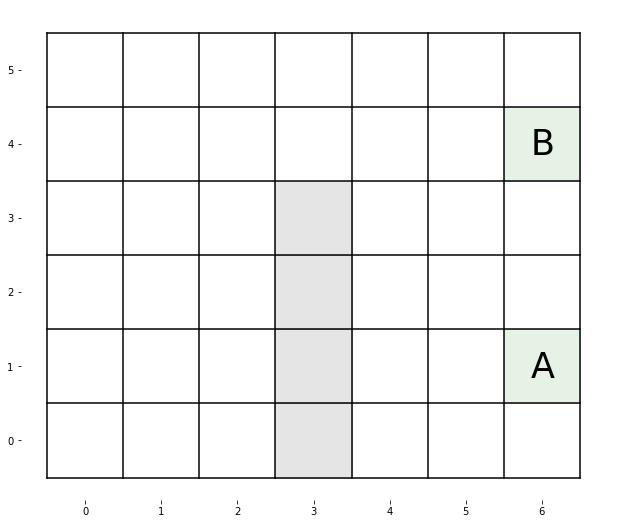

In [11]:
goalStates = [(6,1, "A"), (6,4, "B")]
gridWidth=7
gridHeight=6
trapStates = [(3,0), (3,1), (3,2), (3,3)]
visualizeEnvironment(gridWidth, gridHeight, goalStates, trapStates, trajectory = [])

# Examples

In [12]:
gridWidth = 7
gridHeight = 6
allActions = [(1,0), (0,1), (-1,0), (0,-1), (-1,1), (1,-1), (1,1), (-1,-1)]
trapStates = [(3,0), (3,1), (3,2), (3,3)]
convergenceThreshold = 10e-7
gamma = .95
beta = .4

np.random.seed(1000)
getTransition = SetupTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

In [13]:
goalStateB = (6,1)
getRewardB = SetupRewardTable(transition, allActions, goalStateB, trapStates)
rewardB = getRewardB()

valueB = {state:0 for state in rewardB.keys()}


performValueIterationB = ValueIteration(transition, rewardB, valueB, convergenceThreshold, gamma, beta)
optimalValuesB, policyB = performValueIterationB()

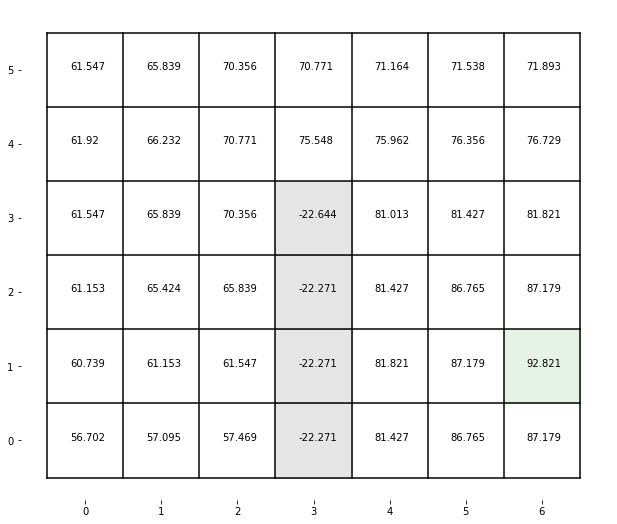

In [14]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateB, trapStates = trapStates, valueTable = optimalValuesB)

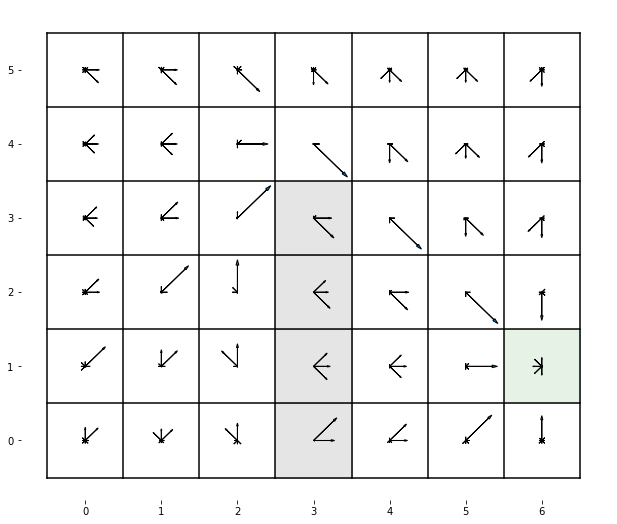

In [15]:
visualizePolicy(gridWidth, gridHeight, goalStateB, trapStates, policyB)

In [16]:
trajectoryToGoalB = [(0,0), (1,1), (2,2), (2,3), (3,4), (4,3), (5,2), (6,1)]

In [17]:
goalStateC = (1,5)

getRewardC = SetupRewardTable(transition, allActions, goalStateC, trapStates)
rewardC = getRewardC()

valueC = {state:0 for state in rewardC.keys()}


performValueIterationC = ValueIteration(transition, rewardC, valueC, convergenceThreshold, gamma, beta)
optimalValuesC, policyC = performValueIterationC()

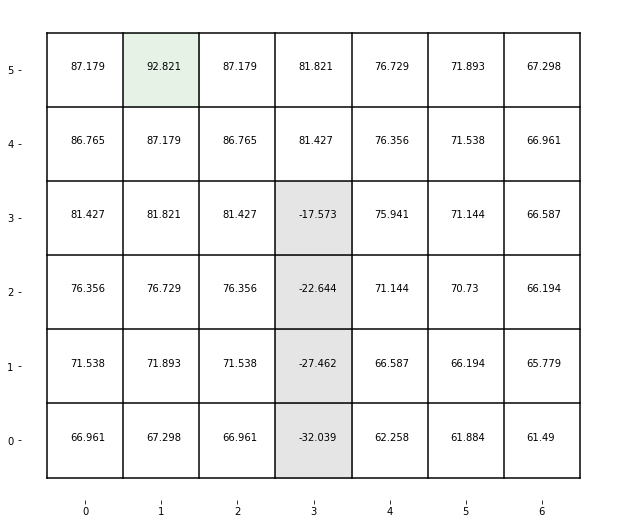

In [18]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateC, trapStates = trapStates, valueTable = optimalValuesC)

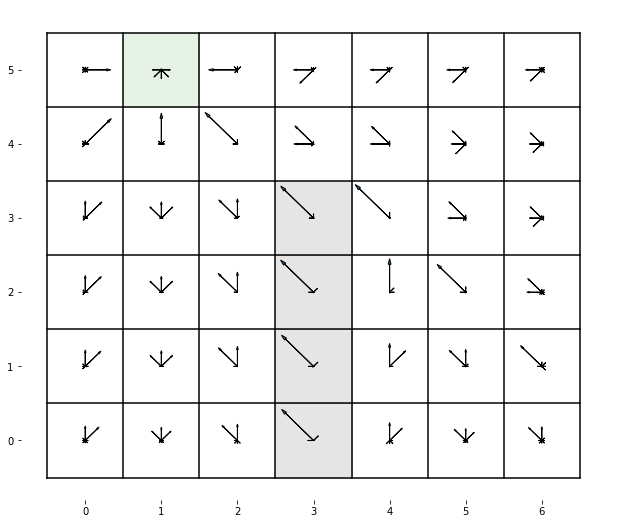

In [19]:
visualizePolicy(gridWidth, gridHeight, goalStateC, trapStates, policyC)

In [20]:
trajectoryToGoalC = [(0,0), (0,1), (1,2), (1,3), (1,4), (1,5)]

In [21]:
goalStateA = (6,4)

getRewardA = SetupRewardTable(transition, allActions, goalStateA, trapStates)
rewardA = getRewardA()

valueA = {state:0 for state in rewardA.keys()}


performValueIterationA = ValueIteration(transition, rewardA, valueA, convergenceThreshold, gamma, beta)
optimalValuesA, policyA = performValueIterationA()

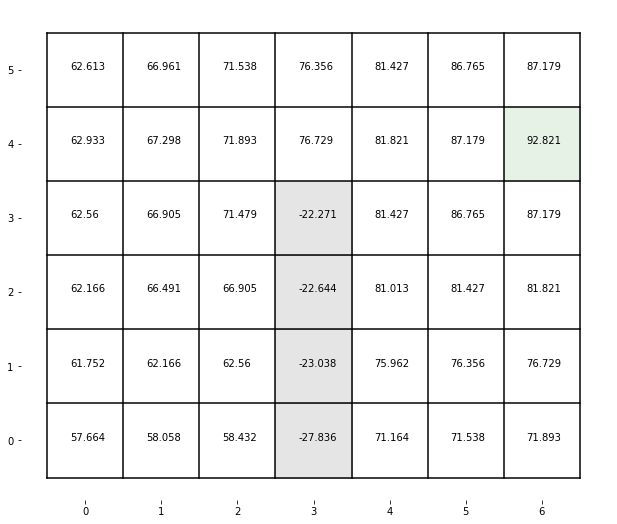

In [22]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateA, trapStates = trapStates, valueTable = optimalValuesA)

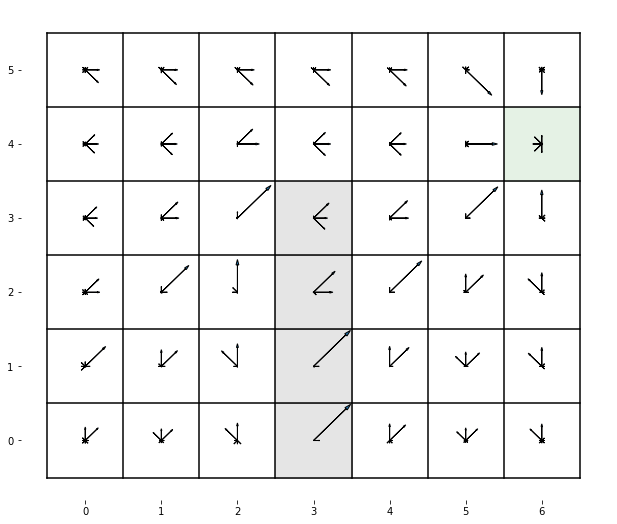

In [23]:
visualizePolicy(gridWidth, gridHeight, goalStateA, trapStates, policyA)

In [24]:
trajectoryToGoalA = [(0,0), (1,1), (1,2), (2,3), (3,4), (4,4), (5,4), (6,4)]

# Example 2

In [25]:
gridWidth = 7
gridHeight = 6
allActions = [(1,0), (0,1), (-1,0), (0,-1), (-1,1), (1,-1), (1,1), (-1,-1)]
trapStates = [(3,0), (3,2), (3,3)]
convergenceThreshold = 10e-7
gamma = .95
beta = .4

np.random.seed(1000)
getTransition = SetupTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

In [26]:
goalStateC = (1,5)

env2getRewardC = SetupRewardTable(transition, allActions, goalStateC, trapStates)
env2rewardC = env2getRewardC()

env2valueC = {state:0 for state in env2rewardC.keys()}


env2performValueIterationC = ValueIteration(transition, env2rewardC, env2valueC, convergenceThreshold, gamma, beta)
env2optimalValuesC, env2policyC = env2performValueIterationC()

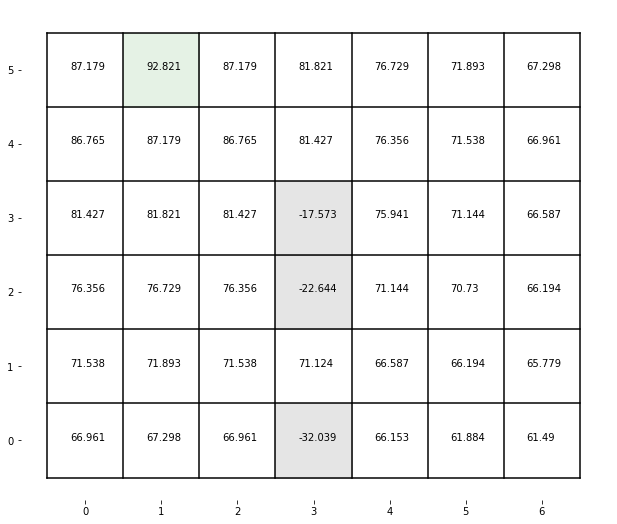

In [27]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateC, trapStates = trapStates, valueTable = env2optimalValuesC)

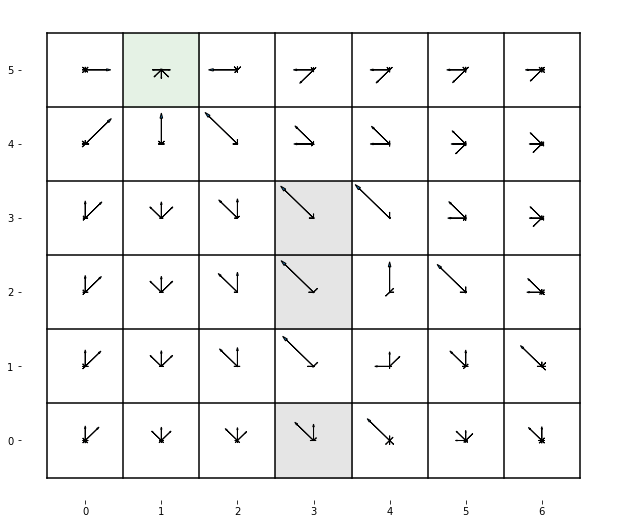

In [28]:
visualizePolicy(gridWidth, gridHeight, goalStateC, trapStates, env2policyC)

In [29]:
goalStateA = (6,4)

env2getRewardA = SetupRewardTable(transition, allActions, goalStateA, trapStates)
env2rewardA = env2getRewardA()

env2valueA = {state:0 for state in env2rewardA.keys()}


env2performValueIterationA = ValueIteration(transition, env2rewardA, env2valueA, convergenceThreshold, gamma, beta)
env2optimalValuesA, env2policyA = env2performValueIterationA()

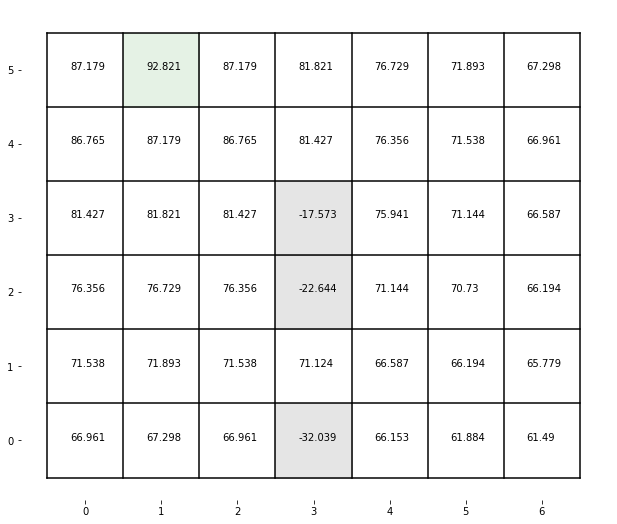

In [30]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateC, trapStates = trapStates, valueTable = env2optimalValuesC)

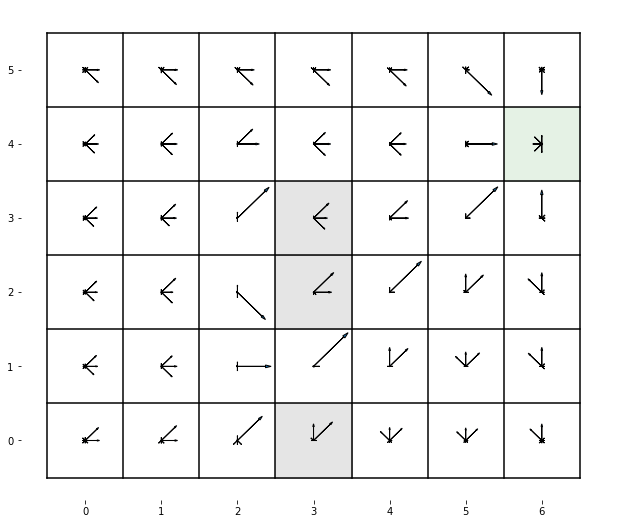

In [31]:
visualizePolicy(gridWidth, gridHeight, goalStateA, trapStates, env2policyA)

In [32]:
goalStateB = (6,1)

env2getRewardB = SetupRewardTable(transition, allActions, goalStateB, trapStates)
env2rewardB = env2getRewardB()

env2valueB = {state:0 for state in env2rewardB.keys()}


env2performValueIterationB = ValueIteration(transition, env2rewardB, env2valueB, convergenceThreshold, gamma, beta)
env2optimalValuesB, env2policyB = env2performValueIterationB()

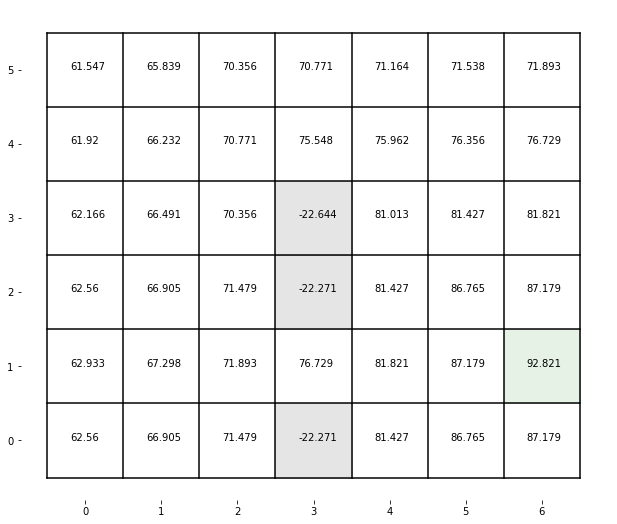

In [33]:
visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = goalStateB, trapStates = trapStates, valueTable = env2optimalValuesB)

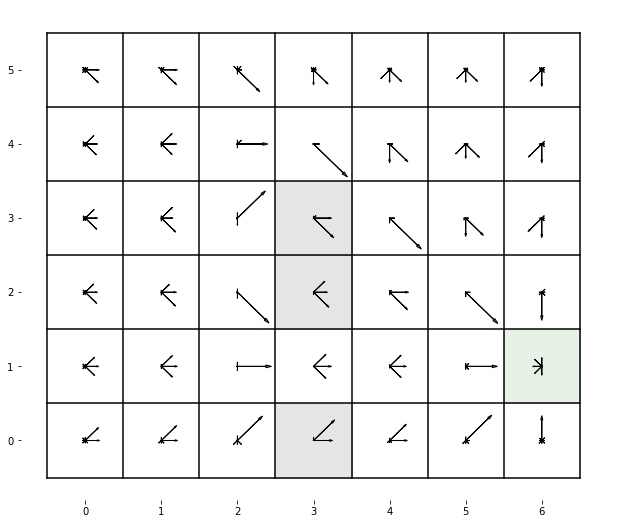

In [34]:
visualizePolicy(gridWidth, gridHeight, goalStateB, trapStates, env2policyB)